<a href="https://colab.research.google.com/github/ricardotds/GoogleColab/blob/master/Mini_Turing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
import numpy as np
from sklearn.utils.validation import check_is_fitted
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import pandas.core.algorithms as algos
from pandas import Series
from pandas import DataFrame
from collections import defaultdict
from sklearn import metrics, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import joblib
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from functools import reduce
import matplotlib.pyplot as plt
import scipy.stats.stats as stats
import re
import traceback
import seaborn as sns
import subprocess
import warnings
import math
import time, sys
import string
from IPython.display import HTML, display

# Functions

## Progress Bar

In [0]:
def update_progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
# import time
# out = display(update_progress(0, 100), display_id=True)
# for ii in range(101):
#     time.sleep(0.02)
#     out.update(update_progress(ii, 100))

## Variance Infation Factor

In [0]:
def calculate_vif(features):
  vif = pd.DataFrame()
  vif["Features"] = features.columns
  vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
  return(vif)

## Binners

In [0]:
def dt_binner(df,columns):
  binner_dict_ = {}
  scores_dict_ = {}
  chars_dict_ = {}
  probas_list_ = {}
  chars_list_ = {}
  number_of_elements = len(columns)
  count = 1
  out = display(update_progress(0, 100), display_id=True)
  for var in columns:
    df_var_miss = df.loc[np.isnan(df[var]) == True, var]
    df_var_nomiss = df.loc[np.isnan(df[var]) == False, var]
    df_target_miss = df.loc[np.isnan(df[var]) == True, 'target']
    df_target_nomiss = df.loc[np.isnan(df[var]) == False, 'target']

    tree_model = GridSearchCV(DecisionTreeClassifier(random_state=666),cv=3,scoring='neg_mean_squared_error',param_grid={'max_depth':[1,2,3,4,5],'max_leaf_nodes': [2,4,8,12,15,19]})

    x_train, x_test, y_train, y_test = train_test_split(df_var_nomiss,df_target_nomiss, test_size=0.3, random_state=666)

    tree_model.fit(x_train.to_frame(),y_train)

    binner_dict_[var] = tree_model
    scores_dict_[var] = tree_model.score(x_train.to_frame(), y_train)

    vars_dis = 'bin_' + var

    df_var_nomiss_score = df_var_nomiss.copy()

    df_var_nomiss_score_s = pd.DataFrame(binner_dict_[var].predict_proba(df_var_nomiss_score.to_frame())[:,1],index=df_var_nomiss_score.to_frame().index)

    df_var_nomiss_score_s.columns = [var]

    probas = list(df_var_nomiss_score_s[var].unique())

    chars = []
    chars_dict_[var] = {}
    for i in range(len(probas)):
      chars.append(string.ascii_uppercase[i])
      chars_dict_[var][probas[i]] = string.ascii_uppercase[i]

    chars_list_[var] = chars
    probas_list_[var] = probas

    df_var_nomiss_score_s[var].replace(probas,chars,inplace=True)

    df[vars_dis] = df_var_nomiss_score_s[var]

    # X_train['bin']=tree_model.predict_proba(X_train[var].to_frame())[:,1]
    # df_tmp = pd.concat([X_train.groupby(['bin'])[var].min(),X_train.groupby(['bin'])[var].max()], axis=1)
    # df_tmp.collumns = ['min','max']
    # df_tmp['range'] = '(' + str(df_tmp['min']) + '<=x<=' + str(df_tmp['max']) + ')'

    
    out.update(update_progress((count / number_of_elements)*100, 100))
    count = count + 1
  out.update(update_progress(100, 100))
  return (df, binner_dict_, scores_dict_, chars_dict_, probas_list_, chars_list_)


In [0]:
def apply_binner(df,vars_binner,model_dict,chars_dict,probas_dict):
  number_of_elements = len(vars_binner)
  count = 1
  out = display(update_progress(0, 100), display_id=True)
  for var in vars_binner:
    df_var_miss = df.loc[np.isnan(df[var]) == True, var]
    df_var_nomiss = df.loc[np.isnan(df[var]) == False, var]

    tree_model = model_dict[var]
    probas = probas_dict[var]
    chars = chars_dict[var]

    if df_var_nomiss.shape[0] > 0:
      df_var_nomiss_score = df_var_nomiss.copy()
      df_var_nomiss_score_s = pd.DataFrame(tree_model.predict_proba(df_var_nomiss_score.to_frame())[:,1],index=df_var_nomiss_score.to_frame().index)
      df_var_nomiss_score_s.columns = [var]
      df_var_nomiss_score_s[var].replace(probas,chars,inplace=True)
      df['bin_'+var] = df_var_nomiss_score_s[var]
    else:
      df['bin_'+var] = 'NA'


    out.update(update_progress((count / number_of_elements)*100, 100))
    count = count + 1
  out.update(update_progress(100, 100))
  
  return df


In [0]:
def mono_bin(Y, X, n):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]
  r = 0
  while np.abs(r) < 1:
      try:
          d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
          d2 = d1.groupby('Bucket', as_index=True)
          r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
          n = n - 1 
      except:
          n = n - 1

  if len(d2) == 1:
      n = force_bin         
      bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
      if len(np.unique(bins)) == 2:
          bins = np.insert(bins, 0, 1)
          bins[1] = bins[1]-(bins[1]/2)
      d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
      d2 = d1.groupby('Bucket', as_index=True)
  
  d3 = pd.DataFrame({},index=[])
  d3["MIN_VALUE"] = d2.min().X
  d3["MAX_VALUE"] = d2.max().X
  d3["COUNT"] = d2.count().Y
  d3["EVENT"] = d2.sum().Y
  d3["NONEVENT"] = d2.count().Y - d2.sum().Y
  d3=d3.reset_index(drop=True)
  
  if len(justmiss.index) > 0:
      d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
      d4["MAX_VALUE"] = np.nan
      d4["COUNT"] = justmiss.count().Y
      d4["EVENT"] = justmiss.sum().Y
      d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
      d3 = d3.append(d4,ignore_index=True)
  
  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()
  
  return(d3)



In [0]:
def char_bin(Y, X):    
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]    
  df2 = notmiss.groupby('X',as_index=True)
  
  d3 = pd.DataFrame({},index=[])
  d3["COUNT"] = df2.count().Y
  d3["MIN_VALUE"] = df2.sum().Y.index
  d3["MAX_VALUE"] = d3["MIN_VALUE"]
  d3["EVENT"] = df2.sum().Y
  d3["NONEVENT"] = df2.count().Y - df2.sum().Y
  
  if len(justmiss.index) > 0:
      d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
      d4["MAX_VALUE"] = np.nan
      d4["COUNT"] = justmiss.count().Y
      d4["EVENT"] = justmiss.sum().Y
      d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
      d3 = d3.append(d4,ignore_index=True)
  
  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()
  d3 = d3.reset_index(drop=True)
  
  return(d3)



In [0]:
def data_vars(df1, target, n):
  stack = traceback.extract_stack()
  filename, lineno, function_name, code = stack[-2]
  vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
  final = (re.findall(r"[\w']+", vars_name))[-1]
  
  x = df1.dtypes.index
  count = -1
  number_of_elements = len(df.columns)
  ct = 1
  out = display(update_progress(0, 100), display_id=True)
  
  for i in x:
      if i.upper() not in (final.upper()):
          if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
              conv = mono_bin(target, df1[i],n)
              conv["VAR_NAME"] = i
              count = count + 1
          else:
              conv = char_bin(target, df1[i])
              conv["VAR_NAME"] = i            
              count = count + 1
              
          if count == 0:
              iv_df = conv
          else:
              iv_df = iv_df.append(conv,ignore_index=True)
      out.update(update_progress((ct / number_of_elements)*100, 100))
      ct = ct + 1
  out.update(update_progress(100, 100))
  iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
  iv = iv.reset_index()
  return(iv_df,iv)

## Models

In [0]:
def runModel(modelType,features_train,label_train,features_test,label_test):
    
    def runClf(): 
        clf.fit(features_train,label_train)
        
        pred_train = clf.predict(features_train)
        pred_test = clf.predict(features_test)
        
        
        accuracy_train = accuracy_score(pred_train,label_train)
        accuracy_test = accuracy_score(pred_test,label_test)
        
        fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
        auc_train = metrics.auc(fpr,tpr)
        
        fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
        auc_test = metrics.auc(fpr,tpr)
        
        print('accuracy_train: {}\naccuracy_test: {}\nauc_train: {}\nauc_test: {}'.format(accuracy_train,accuracy_test,auc_train,auc_test))
        print('\n\n\nAssertivity - Train\n')
        print(pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED']))
        print('\n\n\nAssertivity - Test\n')
        print(pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED']))
        
        scores_train = scoring(features_train,clf,label_train)
        scores_test = scoring(features_test,clf,label_test)
        lift_train = pd.concat([features_train,scores_train],axis=1)
        lift_test = pd.concat([features_test,scores_test],axis=1)
        
        return clf, scores_train, scores_test, lift_train, lift_test
    
    if modelType == 'RF':
        print('Random Forest Classifier - n_estimators: {}'.format(nEstimatorsRF))
        clf = RandomForestClassifier(n_estimators=nEstimatorsRF)
        return runClf()
    elif modelType == 'LR':
        print('Logistic Regression')
        clf = LogisticRegression(solver='lbfgs')   
        return runClf()
    elif modelType == 'NN':
        print('Neural Network')
        clf = MLPClassifier()
        return runClf()
    elif modelType == 'NB':
        print('Naive Bayes')
        clf = GaussianNB()
        return runClf()
    elif modelType == 'GB':
        print('Gradient Boost')    
        clf = GradientBoostingClassifier()
        return runClf()
    elif modelType == 'RFHP':
        print('Random Forest - Hyper Parameter Tuning')
        n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
        max_features = ['auto', 'sqrt']
        max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
        max_depth.append(None)
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [1, 2, 4]
        bootstrap = [True, False]
        
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
        
        rf = RandomForestClassifier()
        
        rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
        rf_random.fit(features_train, label_train)
        
        print(rf_random.best_params_)
        clf = RandomForestClassifier(**rf_random.best_params_)
        return runClf()
    elif modelType == 'GBHP':
        print('Gradient Boost - Hyper Parameter Tuning')
        n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
        max_features = ['auto', 'sqrt']
        max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
        max_depth.append(None)
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [1, 2, 4]
        
        grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
        
        gb = GradientBoostingClassifier()
        
        gf_tune = GridSearchCV(estimator = gb, param_grid = grid, cv = 2, verbose=2, n_jobs = -1)
        gf_tune.fit(features_train, label_train)
        
        print(gf_tune.best_params_)
        clf = GradientBoostingClassifier(**gf_tune.best_params_)
        return runClf()

In [0]:
def modelSelection(df1,vif):
    print('\n\n\n################################################################')
    print('Spliting the dataframe into train and test - test_size: {}'.format(testSize))
    train, test = train_test_split(df1, test_size = testSize)
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    fTrain = train[list(vif['Features'])]
    lTrain = train['target']
    fTest = test[list(vif['Features'])]
    lTest = test['target']
    
    clfRF, scores_train, scores_test, lift_train, lift_test = runModel('RF',fTrain,lTrain,fTest,lTest) #RandomForest
    #printCharts(scores_train,scores_test,lift_train,lift_test)
    
    clfLR, scores_train, scores_test, lift_train, lift_test = runModel('LR',fTrain,lTrain,fTest,lTest) #LogisticRegression
    #printCharts(scores_train,scores_test,lift_train,lift_test)
    
    clfNN, scores_train, scores_test, lift_train, lift_test = runModel('NN',fTrain,lTrain,fTest,lTest) #NeuralNetwork
    #printCharts(scores_train,scores_test,lift_train,lift_test)
    
    clfNB, scores_train, scores_test, lift_train, lift_test = runModel('NB',fTrain,lTrain,fTest,lTest) #NaiveBayes
    #printCharts(scores_train,scores_test,lift_train,lift_test)
    
    clfGB, scores_train, scores_test, lift_train, lift_test = runModel('GB',fTrain,lTrain,fTest,lTest) #GradientBoost
    #printCharts(scores_train,scores_test,lift_train,lift_test)
    
    clfRFHP, scores_train, scores_test, lift_train, lift_test = runModel('RFHP',fTrain,lTrain,fTest,lTest) #RandomForestHyperParameter
    #printCharts(scores_train,scores_test,lift_train,lift_test)
    
    clfGBHP, scores_train, scores_test, lift_train, lift_test = runModel('GBHP',fTrain,lTrain,fTest,lTest) #GradientBoostHyperParameter
    #printCharts(scores_train,scores_test,lift_train,lift_test)
    
    return clfRF, clfLR, clfNN, clfNB, clfGB, clfRFHP, clfGBHP

## Plots

In [0]:
def printCharts(scores_train,scores_test,lift_train,lift_test):
    print(deciling(scores_train,['DECILE'],'TARGET','NONTARGET'))
    print(deciling(scores_test,['DECILE'],'TARGET','NONTARGET'))
    print(gains(lift_train,['DECILE'],'TARGET','SCORE'))
    print(gains(lift_test,['DECILE'],'TARGET','SCORE'))

In [0]:
def plot_pandas_style(styler):
  from IPython.core.display import HTML
  html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
  return HTML(html)



In [0]:
def highlight_max(s,color='yellow'):
  '''
  highlight the maximum in a Series yellow.
  '''
  is_max = s == s.max()
  return ['background-color: {}'.format(color) if v else '' for v in is_max]



In [0]:
def decile_labels(agg1,label,color='skyblue'):
  agg_dummy = pd.DataFrame(OrderedDict((('TOTAL',0),('TARGET',0),('NONTARGET',0),('PCT_TAR',0),('CUM_TAR',0),('CUM_NONTAR',0),('DIST_TAR',0),('DIST_NONTAR',0),('SPREAD',0))),index=[0])
  agg1 = agg1.append(agg_dummy).sort_index()
  agg1.index.name = label
  agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['SPREAD'])
  agg1.bar(subset=['TARGET'], color='{}'.format(color))
  agg1.bar(subset=['TOTAL'], color='{}'.format(color))
  agg1.bar(subset=['PCT_TAR'], color='{}'.format(color))
  return(agg1)



In [0]:
def deciling(data,decile_by,target,nontarget):
  inputs = list(decile_by)
  inputs.extend((target,nontarget))
  decile = data[inputs]
  grouped = decile.groupby(decile_by)
  agg1 = pd.DataFrame({},index=[])
  agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
  agg1['TARGET'] = grouped.sum()[target]
  agg1['NONTARGET'] = grouped.sum()[nontarget]
  agg1['PCT_TAR'] = grouped.mean()[target]*100
  agg1['CUM_TAR'] = grouped.sum()[target].cumsum()
  agg1['CUM_NONTAR'] = grouped.sum()[nontarget].cumsum()
  agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].sum()*100
  agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].sum()*100
  agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
  agg1 = decile_labels(agg1,'DECILE',color='skyblue')
  return(plot_pandas_style(agg1))
    


In [0]:
def scoring(features,clf,target):
  score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
  score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
  score['DECILE'] = score['DECILE'].astype(float)
  score['TARGET'] = target
  score['NONTARGET'] = 1 - target
  return(score)
    


In [0]:
def plots(agg1,target,type):

  plt.figure(1,figsize=(20, 5))

  plt.subplot(131)
  plt.plot(agg1['DECILE'],agg1['ACTUAL'],label='Actual')
  plt.plot(agg1['DECILE'],agg1['PRED'],label='Pred')
  plt.xticks(range(10,110,10))
  plt.legend(fontsize=15)
  plt.grid(True)
  plt.title('Actual vs Predicted', fontsize=20)
  plt.xlabel("Population %",fontsize=15)
  plt.ylabel(str(target) + " " + str(type) + " %",fontsize=15)

  plt.subplot(132)
  X = agg1['DECILE'].tolist()
  X.append(0)
  Y = agg1['DIST_TAR'].tolist()
  Y.append(0)
  plt.plot(sorted(X),sorted(Y))
  plt.plot([0, 100], [0, 100],'r--')
  plt.xticks(range(0,110,10))
  plt.yticks(range(0,110,10))
  plt.grid(True)
  plt.title('Gains Chart', fontsize=20)
  plt.xlabel("Population %",fontsize=15)
  plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
  plt.annotate(round(agg1[agg1['DECILE'] == 30].DIST_TAR.item(),2),xy=[30,30], 
          xytext=(25, agg1[agg1['DECILE'] == 30].DIST_TAR.item() + 5),fontsize = 13)
  plt.annotate(round(agg1[agg1['DECILE'] == 50].DIST_TAR.item(),2),xy=[50,50], 
          xytext=(45, agg1[agg1['DECILE'] == 50].DIST_TAR.item() + 5),fontsize = 13)

  plt.subplot(133)
  plt.plot(agg1['DECILE'],agg1['LIFT'])
  plt.xticks(range(10,110,10))
  plt.grid(True)
  plt.title('Lift Chart', fontsize=20)
  plt.xlabel("Population %",fontsize=15)
  plt.ylabel("Lift",fontsize=15)

  plt.tight_layout()





In [0]:
def gains(data,decile_by,target,score):
  inputs = list(decile_by)
  inputs.extend((target,score))
  decile = data[inputs]
  grouped = decile.groupby(decile_by)
  agg1 = pd.DataFrame({},index=[])
  agg1['ACTUAL'] = grouped.mean()[target]*100
  agg1['PRED'] = grouped.mean()[score]*100
  agg1['DIST_TAR'] = grouped.sum()[target].cumsum()/grouped.sum()[target].sum()*100
  agg1.index.name = 'DECILE'
  agg1 = agg1.reset_index()
  agg1['DECILE'] = agg1['DECILE']*10
  agg1['LIFT'] = agg1['DIST_TAR']/agg1['DECILE']
  plots(agg1,target,'Distribution')

## Metadata

In [0]:
def ajusteMetadados(dataframe): 
  train = dataframe
  # Verifica os tipos de variáveis presentes na tabela de treino
  t = []
  for i in train.columns:
          t.append(train[i].dtype)

  n = []
  for i in train.columns:
          n.append(i)

  aux_t = pd.DataFrame(data=t,columns=["Types"])
  aux_n = pd.DataFrame(data=n,columns=["Features"])
  df_tipovars = pd.concat([aux_n, aux_t], axis=1, join_axes=[aux_n.index])
  data = []
  for f in train.columns:

      # Definindo o papel das variáveis:
      if f == 'target':
          role = 'target'
      elif f == 'id':
          role = 'id'
      else:
          role = 'input'

      # Definindo o tipo das variáveis: nominal, ordinal, binary ou interval
      if f == 'target':
          level = 'binary'
      if train[f].dtype == 'object' or f == 'id': 
          level = 'nominal'
      elif train[f].dtype in ['float','float64'] :
          level = 'interval'
      elif train[f].dtype in ['int','int64'] :
          level = 'ordinal'

      # Todas variáveis são incializadas com keep exceto o id
      keep = True
      if f == 'id':
          keep = False

      # Definindo o tipo das variáveis da tabela de entrada
      dtype = train[f].dtype

      # Criando a lista com todo metadados
      f_dict = {
          'Features': f,
          'Role': role,
          'Level': level,
          'Keep': keep,
          'Type': dtype
      }
      data.append(f_dict)

  meta = pd.DataFrame(data, columns=['Features', 'Role', 'Level', 'Keep', 'Type'])

  # Quantidade de domínios distintos para cada cariável do tipo ordinal e nominal
  card = []

  v = train.columns
  for f in v:
      dist_values = train[f].value_counts().shape[0]
      f_dict = {
              'Features': f,
              'Cardinality': dist_values
          }
      card.append(f_dict)

  card = pd.DataFrame(card, columns=['Features', 'Cardinality'])

  metadados_train = pd.merge(meta, card, on='Features')

  return metadados_train

# Execution

## Params

In [0]:
max_bin = 20
force_bin = 5
nEstimatorsRF = 100
nEstimatorsETC = 100
maxIterRFE = 50
maxIterL1 = 100
kChiSq = 'all'
minVarScore = 2
maxVarianceInflationFactor = 5
testSize = 0.3
exports = []
pd.options.display.max_columns = None

## Importing DF

In [0]:
dfTemp = pd.read_csv('/content/drive/My Drive/Persona/SP.txt',delimiter=';')
dfTemp_auto = pd.read_csv('/content/drive/My Drive/Persona/SP_auto.txt',delimiter=',')
dfGames = pd.read_excel('/content/drive/My Drive/Persona/Resultados.xlsx')
dfGames['Data Sorteio'] = dfGames['Data Sorteio'].dt.strftime('%Y%m%d')
dfTemp_auto = dfTemp_auto.rename(index=str, columns={'data':'Data','hora':'Hora'})
dfTemp['Data'] = pd.to_datetime(dfTemp['Data']).dt.strftime('%Y%m%d')
dfTemp_auto['Data'] = pd.to_datetime(dfTemp_auto['Data']).dt.strftime('%Y%m%d')
dfTemp_auto = dfTemp_auto.drop(columns=['radiacao', 'precipitacao'])
dfHora = dfTemp[['Data','Hora']].groupby(['Data']).max()
dfHora = dfHora.rename(index=str, columns={"Hora": "horaMax"})
dfTemp = pd.merge(dfTemp, dfHora, on='Data')
dfTemp = dfTemp.loc[dfTemp['Hora'] == dfTemp['horaMax']]
dfTemp = dfTemp.drop(columns=['Estacao', 'Unnamed: 7','horaMax'])
dfTemp_auto = dfTemp_auto.loc[dfTemp_auto['Hora'] == 20]
dfGamesSP = dfGames.loc[dfGames['Cidade'] == 'SÃO PAULO']
dfGamesSP = dfGamesSP.rename(index=str, columns={'Data Sorteio': 'Data'} )
for x in range(1,26):
    dfGamesSP['X_{}'.format(x)] = (dfGamesSP==x).sum(axis=1)
    dfGamesSP['X_{}'.format(x)] = dfGamesSP['X_{}'.format(x)].astype(int)
dfMerge = pd.merge(dfGamesSP, dfTemp, on='Data')
dfMergeA = pd.merge(dfGamesSP, dfTemp_auto, on='Data')
dfTemp_mix = pd.merge(dfTemp, dfTemp_auto, on='Data')
dfMergeMix = pd.merge(dfGamesSP, dfTemp_mix, on='Data')

In [21]:
dfMerge.columns

Index(['HTML', 'Concurso', 'Cidade', 'Estado', 'Local', 'Data Unix', 'Data',
       'Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6', 'Bola7', 'Bola8',
       'Bola9', 'Bola10', 'Bola11', 'Bola12', 'Bola13', 'Bola14', 'Bola15',
       'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10',
       'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18', 'X_19',
       'X_20', 'X_21', 'X_22', 'X_23', 'X_24', 'X_25', 'Hora', 'TempBulboSeco',
       'TempBulboUmido', 'UmidadeRelativa', 'PressaoAtmEstacao'],
      dtype='object')

In [0]:
resposta = 'X_1'

In [0]:
df001 = dfMerge[['TempBulboSeco', 'TempBulboUmido', 'UmidadeRelativa', 'PressaoAtmEstacao','X_1']].copy()

In [24]:
# df001 = pd.read_csv('')

df001.rename(columns={resposta:'target'},inplace=True)
df001.shape

(312, 5)

## Data Prep

#### Metadados

In [25]:
metadados = ajusteMetadados(df001)
metadados

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  


,Features,Role,Level,Keep,Type,Cardinality
0,TempBulboSeco,input,interval,True,float64,138
1,TempBulboUmido,input,interval,True,float64,105
2,UmidadeRelativa,input,ordinal,True,int64,73
3,PressaoAtmEstacao,input,interval,True,float64,129
4,target,target,ordinal,True,int64,2


In [0]:
dfInput = df001.copy()
df01 = df001[df001.columns.difference(['target'])]

#### Missings

In [27]:
df01_missing = df01.isnull().sum()
qt_rows = df01.shape[0]

# Gerando data frame com quantidade de missings por variavel
df_pct_missing = pd.DataFrame(df01_missing,columns=['qt_missing'])
df_pct_missing = pd.DataFrame(df01_missing,columns=['qt_missing'])
df_pct_missing['Features'] = df_pct_missing.index
df_pct_missing['pc_miss'] = (100*df_pct_missing['qt_missing'].divide(qt_rows)).astype(int)
df_pct_missing['qt_rows'] = qt_rows
df_pct_missing.reset_index(drop = True, inplace = True)

df_pct_missing

,qt_missing,Features,pc_miss,qt_rows
0,0,PressaoAtmEstacao,0,312
1,0,TempBulboSeco,0,312
2,23,TempBulboUmido,7,312
3,0,UmidadeRelativa,0,312


##### Numeric Fillable with Zero

In [0]:
filter_numeric = ['TempBulboSeco','UmidadeRelativa','PressaoAtmEstacao']
df01_1 = df01[filter_numeric]
df01_2 = df01[df01.columns.difference(filter_numeric)]

In [0]:
df_numeric = df01_1.fillna(0)

##### Scaler

In [0]:
scaler = StandardScaler()
df02 = df_numeric.astype(float)
scaled_fit = scaler.fit_transform(df02)
df_numeric_scaled = pd.DataFrame(scaled_fit, columns=df_numeric.columns,index=df_numeric.index)
exports.append(scaler)

##### Not Fillable with Zero

In [31]:
df01_2_missing = df01_2.isnull().sum()

# Gerando data frame com quantidade de missings por variavel
df_pct_missing = pd.DataFrame(df01_2_missing,columns=['qt_missing'])
df_pct_missing = pd.DataFrame(df01_2_missing,columns=['qt_missing'])
df_pct_missing['Features'] = df_pct_missing.index
df_pct_missing['pc_miss'] = (100*df_pct_missing['qt_missing'].divide(qt_rows)).astype(int)
df_pct_missing['qt_rows'] = qt_rows
df_pct_missing.reset_index(drop = True, inplace = True)

df_pct_missing

,qt_missing,Features,pc_miss,qt_rows
0,23,TempBulboUmido,7,312


##### Discretization

In [0]:
filter_discretizer = ['TempBulboUmido']
filter_binner = filter_discretizer.copy()
filter_binner.append('target')
vars_dis = dfInput[filter_binner].copy()
vars_others = df01_2[df01_2.columns.difference(filter_discretizer)]

In [33]:
vars_discretized, binner_dict_, scores_dict_, chars_dict_, probas_list_, chars_list_ = dt_binner(vars_dis,filter_discretizer)

In [0]:
vars_discretized.drop(filter_binner,axis=1,inplace=True)
vars_discretized.columns = filter_discretizer

In [0]:
exports.append(binner_dict_)
exports.append(chars_list_)
exports.append(probas_list_)

##### Categoric

In [36]:
filter_others = list(vars_others.columns)
metadados[metadados['Features'].isin(filter_others)]

,Features,Role,Level,Keep,Type,Cardinality


In [0]:
vars_manual = []
vars_encoder = []

In [0]:
vars_cat_NA = pd.merge(vars_discretized,vars_others[vars_others.columns.difference(vars_manual + vars_encoder)], left_index=True, right_index=True)
vars_cat_LE = vars_others[vars_encoder]
vars_cat_MA = vars_others[vars_manual]

In [0]:
df02_2 = vars_cat_NA.fillna('NA')
df02_3 = vars_cat_MA.fillna('Constante')

##### Dummies

In [40]:
df_pre_dummies = pd.merge(df02_2,df02_3, left_index=True, right_index=True)
vars_to_dummify = ajusteMetadados(df_pre_dummies)
vars_to_dummify

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  


,Features,Role,Level,Keep,Type,Cardinality
0,TempBulboUmido,input,nominal,True,object,3


In [41]:
df_pre_dummies.isnull().sum()

TempBulboUmido    0
dtype: int64

In [42]:
df_pre_dummies.shape

(312, 1)

In [0]:
df_dummies = pd.get_dummies(df_pre_dummies,prefix=df_pre_dummies.columns,prefix_sep='_',drop_first=True,columns=df_pre_dummies.columns)

In [44]:
df_dummies.shape

(312, 2)

In [0]:
df_dummies.columns = [col.replace(' ','') for col in df_dummies.columns]

##### High Cardinality Nominals

In [46]:
vars_to_le = ajusteMetadados(vars_cat_LE)
vars_to_le

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  


,Role,Level,Keep,Type,Features,Cardinality


In [47]:
vars_cat_LE.isnull().sum()

Series([], dtype: float64)

In [0]:
df_le = vars_cat_LE.fillna('NA')

In [0]:
# LE_coluna = preprocessing.LabelEncoder()
# LE_coluna_fit = LE_coluna.fit_transform(df_le['coluna'].astype(str))
# LE_coluna_df = pd.DataFrame(LE_coluna_fit,columns=['coluna'],index=df_le.index)
# exports.append(LE_coluna)

##### ABT

In [0]:
df_tmp1 = pd.merge(df_numeric_scaled,df_dummies,left_index=True,right_index=True)
df_tmp2 = pd.merge(df_tmp1,df_le,left_index=True,right_index=True)
ABT_df = pd.merge(df_tmp2,dfInput[['target']],left_index=True,right_index=True)

In [0]:
df_tmp3 = pd.merge(df_numeric,df_pre_dummies,left_index=True,right_index=True)
df_tmp4 = pd.merge(df_tmp3,df_le,left_index=True,right_index=True)
WOE_df = pd.merge(df_tmp4,dfInput[['target']],left_index=True,right_index=True)

## Feature Selection

### Descriptive Stats

In [52]:
df = WOE_df
print('Descriptive Stats\n')
print(df.target.value_counts())
print(df.target.value_counts()/len(df))
print(df.describe())

Descriptive Stats

1    188
0    124
Name: target, dtype: int64
1    0.602564
0    0.397436
Name: target, dtype: float64
       TempBulboSeco  UmidadeRelativa  PressaoAtmEstacao      target
count     312.000000       312.000000         312.000000  312.000000
mean       24.235897        60.419872         926.312179    0.602564
std         4.484757        17.916383           3.467142    0.490154
min        12.100000        19.000000         918.400000    0.000000
25%        21.100000        45.000000         923.975000    0.000000
50%        24.200000        61.500000         925.950000    1.000000
75%        27.350000        74.000000         928.300000    1.000000
max        34.900000        98.000000         937.000000    1.000000



Correlation graph

AxesSubplot(0.125,0.125;0.62x0.755)


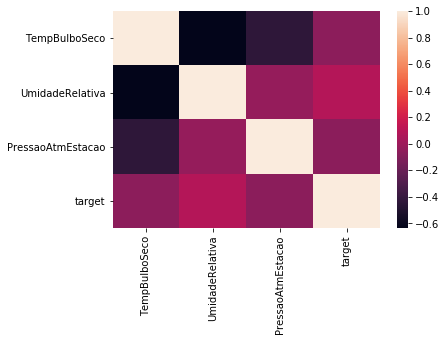

In [53]:
print('\nCorrelation graph\n')
%matplotlib inline
corr = df.corr()
print(sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns))

In [54]:
print('Spliting the dataframe into features and labels\n')
features = df[df.columns.difference(['target'])]
labels = df['target']

Spliting the dataframe into features and labels



### WOE

In [55]:
final_iv, IV = data_vars(df[df.columns.difference(['target'])],df.target,max_bin)
IV = IV.rename(columns={'VAR_NAME':'index'})
print('----\n|IV|\n----\n{}'.format(IV.sort_values(['IV'],ascending=0)))
print('-----\n|WOE|\n-----\n')
transform_vars_list = df.columns.difference(['target'])
transform_prefix = 'new_'
number_of_elements = len(transform_vars_list)
count = 1
out = display(update_progress(0, 100), display_id=True)
for var in transform_vars_list:
  small_df = final_iv[final_iv['VAR_NAME'] == var]
  transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
  replace_cmd = ''
  replace_cmd1 = ''
  for i in sorted(transform_dict.items()):
    replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
    replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
  replace_cmd = replace_cmd + '0'
  replace_cmd1 = replace_cmd1 + '0'
  if replace_cmd != '0':
    try:
      df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd))
    except:
      df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd1))
  out.update(update_progress((count / number_of_elements)*100, 100))
  count = count + 1
out.update(update_progress(100, 100))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


----
|IV|
----
               index        IV
3    UmidadeRelativa  0.031753
1      TempBulboSeco  0.024187
0  PressaoAtmEstacao  0.021343
2     TempBulboUmido  0.000269
-----
|WOE|
-----



In [56]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,PressaoAtmEstacao,918.4,924.6,104,66,0.634615,38,0.365385,0.351064,0.306452,0.135908,0.021343
1,PressaoAtmEstacao,924.7,927.7,105,65,0.619048,40,0.380952,0.345745,0.322581,0.069347,0.021343
2,PressaoAtmEstacao,927.8,937,103,57,0.553398,46,0.446602,0.303191,0.370968,-0.201751,0.021343
3,TempBulboSeco,12.1,21.1,79,50,0.632911,29,0.367089,0.265957,0.233871,0.128567,0.024187
4,TempBulboSeco,21.2,24.2,82,51,0.621951,31,0.378049,0.271277,0.250000,0.081678,0.024187
5,TempBulboSeco,24.4,27.3,73,45,0.616438,28,0.383562,0.239362,0.225806,0.058298,0.024187
6,TempBulboSeco,27.5,34.9,78,42,0.538462,36,0.461538,0.223404,0.290323,-0.262010,0.024187
7,TempBulboUmido,A,A,287,174,0.606272,113,0.393728,0.925532,0.911290,0.015507,0.000269
8,TempBulboUmido,B,B,2,0,0.000000,2,1.000000,0.000000,0.016129,0.000000,0.000269
9,TempBulboUmido,NA,NA,23,14,0.608696,9,0.391304,0.074468,0.072581,0.025672,0.000269


### IV

In [57]:
df = ABT_df
print('Spliting the dataframe into features and labels\n')
features = df[df.columns.difference(['target'])]
labels = df['target']

Spliting the dataframe into features and labels



In [58]:
final_iv, IV = data_vars(df[df.columns.difference(['target'])],df.target,max_bin)
IV = IV.rename(columns={'VAR_NAME':'index'})
print('----\n|IV|\n----\n{}'.format(IV.sort_values(['IV'],ascending=0)))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


----
|IV|
----
               index        IV
4    UmidadeRelativa  0.031753
1      TempBulboSeco  0.024187
0  PressaoAtmEstacao  0.021343
2   TempBulboUmido_B  0.000262
3  TempBulboUmido_NA  0.000052


### Random Forest

In [59]:
clf = RandomForestClassifier(n_estimators=nEstimatorsRF)
clf.fit(features,labels)   
preds = clf.predict(features)    
accuracy = accuracy_score(preds,labels)
print('\n\n\nRandon Forest - n_estimators: {} - Accuracy: {}'.format(nEstimatorsRF,accuracy))
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)
VI = VI.reset_index()
print(VI.sort_values(['RF'],ascending=0))




Randon Forest - n_estimators: 100 - Accuracy: 1.0
               index        RF
0  PressaoAtmEstacao  0.340247
1      TempBulboSeco  0.330876
4    UmidadeRelativa  0.306815
3  TempBulboUmido_NA  0.017339
2   TempBulboUmido_B  0.004724


### ExtraTrees

In [60]:
model = ExtraTreesClassifier(n_estimators=nEstimatorsETC)
model.fit(features, labels)
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)
FI = FI.reset_index()
print('\n\n\nExtra Trees Classifier - n_estimators: {}'.format(nEstimatorsETC))
print(FI.sort_values(['Extratrees'],ascending=0))




Extra Trees Classifier - n_estimators: 100
               index  Extratrees
1      TempBulboSeco    0.344521
0  PressaoAtmEstacao    0.326507
4    UmidadeRelativa    0.302588
3  TempBulboUmido_NA    0.017510
2   TempBulboUmido_B    0.008873


### Chi Square

In [61]:
model = SelectKBest(score_func=chi2, k=kChiSq)
fit = model.fit(features.abs(), labels)
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features.columns)
chi_sq = chi_sq.reset_index()
print('\n\n\nChi Square - k: {}'.format(kChiSq))  
print(chi_sq.sort_values('Chi_Square',ascending=0))




Chi Square - k: all
               index  Chi_Square
2   TempBulboUmido_B        3.03
4    UmidadeRelativa        0.70
1      TempBulboSeco        0.04
3  TempBulboUmido_NA        0.00
0  PressaoAtmEstacao        0.00


### Linear SVC L1

In [62]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=maxIterL1).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)
l1 = l1.reset_index()
print('\n\n\nL1 - max_iter: {}'.format(maxIterL1))  
print(l1[l1['L1'] == True])




L1 - max_iter: 100
Empty DataFrame
Columns: [index, L1]
Index: []


### Recursive Feature Elimination RFE

In [63]:
model = LogisticRegression(solver='lbfgs',max_iter=maxIterRFE)
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()
print('\n\n\nRecursive Feature Elimination - max_iter: {}'.format(maxIterRFE))
print(Selected[Selected['RFE'] == True])




Recursive Feature Elimination - max_iter: 50
               index   RFE
0  PressaoAtmEstacao  True
1      TempBulboSeco  True
2   TempBulboUmido_B  True
3  TempBulboUmido_NA  True
4    UmidadeRelativa  True


### Combining

In [64]:
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']
score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index'] 
for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)     
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)
score_table['final_score'] = score_table.sum(axis=1)
print('\n\n\nScore Table')
print(score_table.sort_values('final_score',ascending=0))




Score Table
               index  IV  RF  Extratrees  Chi_Square  RFE  L1  final_score
0  PressaoAtmEstacao   1   1           1           1    1   0            5
1      TempBulboSeco   1   1           1           1    1   0            5
2   TempBulboUmido_B   1   1           1           1    1   0            5
3  TempBulboUmido_NA   1   1           1           1    1   0            5
4    UmidadeRelativa   1   1           1           1    1   0            5


In [65]:
print('Min VAR Score: {}'.format(minVarScore))
features_selected = features[list(score_table[score_table['final_score'] >= minVarScore]['index'])]
features_selected.shape

Min VAR Score: 2


(312, 5)

### Multicolinearity

In [0]:
final_features = features_selected

In [67]:
vif = calculate_vif(features)
if maxVarianceInflationFactor > 0:
    while vif['VIF'][vif['VIF'] > maxVarianceInflationFactor].any():
        remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
        features.drop(remove,axis=1,inplace=True)
        vif = calculate_vif(features)
print('\n\n\nMulticollinearity - minVarScore: {} - maxVarianceInflationFactor: {}'.format(minVarScore,maxVarianceInflationFactor))




Multicollinearity - minVarScore: 2 - maxVarianceInflationFactor: 5


### Final Vars

In [68]:
final_features.shape

(312, 5)

In [69]:
final_vars = list(vif['Features']) + ['target']
dfModel = df[final_vars]
print(dfModel.describe())

       PressaoAtmEstacao  TempBulboSeco  TempBulboUmido_B  TempBulboUmido_NA  \
count             312.00         312.00            312.00             312.00   
mean               -0.00           0.00              0.01               0.07   
std                 1.00           1.00              0.08               0.26   
min                -2.29          -2.71              0.00               0.00   
25%                -0.68          -0.70              0.00               0.00   
50%                -0.10          -0.01              0.00               0.00   
75%                 0.57           0.70              0.00               0.00   
max                 3.09           2.38              1.00               1.00   

       UmidadeRelativa  target  
count           312.00  312.00  
mean             -0.00    0.60  
std               1.00    0.49  
min              -2.32    0.00  
25%              -0.86    0.00  
50%               0.06    1.00  
75%               0.76    1.00  
max            

In [70]:
campos = WOE_df.columns
colunas = []
for column in features_selected:
  if column in list(df_dummies.columns):
    colunas.append(column.rsplit('_',1)[0])
  else:
    colunas.append(column)
colunas_finais_brutas = np.unique(np.array(colunas)).tolist()
len(colunas_finais_brutas)

4

In [71]:
print(colunas_finais_brutas)

['PressaoAtmEstacao', 'TempBulboSeco', 'TempBulboUmido', 'UmidadeRelativa']


#### Separation by treatment

In [0]:
colunas_fill_zero = []
colunas_discretizer = []
colunas_manuais = []
colunas_encoder = []
colunas_cat = []
for column in colunas_finais_brutas:
  if column in filter_numeric:
    colunas_fill_zero.append(column)
  elif column in filter_discretizer:
    colunas_discretizer.append(column)
  elif column in vars_manual:
    colunas_manuais.append(column)
  elif column in vars_encoder:
    colunas_encoder.append(column)
  else:
    colunas_cat.append(column)

In [73]:
colunas_finais_abertas = list(features_selected.columns)
len(colunas_finais_abertas)

5

In [74]:
print(colunas_finais_abertas)

['PressaoAtmEstacao', 'TempBulboSeco', 'TempBulboUmido_B', 'TempBulboUmido_NA', 'UmidadeRelativa']


In [0]:
colunas_ABT = colunas_finais_abertas.copy()
colunas_ABT.append('target')

In [0]:
exports.append(colunas_finais_brutas)
exports.append(colunas_finais_abertas)
exports.append(colunas_fill_zero)
exports.append(colunas_discretizer)
exports.append(colunas_manuais)
exports.append(colunas_encoder)
exports.append(colunas_cat)

## Model Selection

In [77]:
dfABT_Model = ABT_df[colunas_ABT]
dfABT_Model.shape

(312, 6)

In [78]:
print('Spliting the dataframe into train and test - test_size: {}'.format(testSize))
train, test = train_test_split(dfABT_Model, test_size = testSize, random_state=666)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

fTrain = train[colunas_finais_abertas]
lTrain = train['target']
fTest = test[colunas_finais_abertas]
lTest = test['target']

Spliting the dataframe into train and test - test_size: 0.3


Logistic Regression
accuracy_train: 0.6100917431192661
accuracy_test: 0.6170212765957447
auc_train: 0.6013111888111887
auc_test: 0.5316091954022989



Assertivity - Train

PRED     0    1
ACTUAL         
0       12   76
1        9  121



Assertivity - Test

PRED    0   1
ACTUAL       
0       4  32
1       4  54
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib

None
None


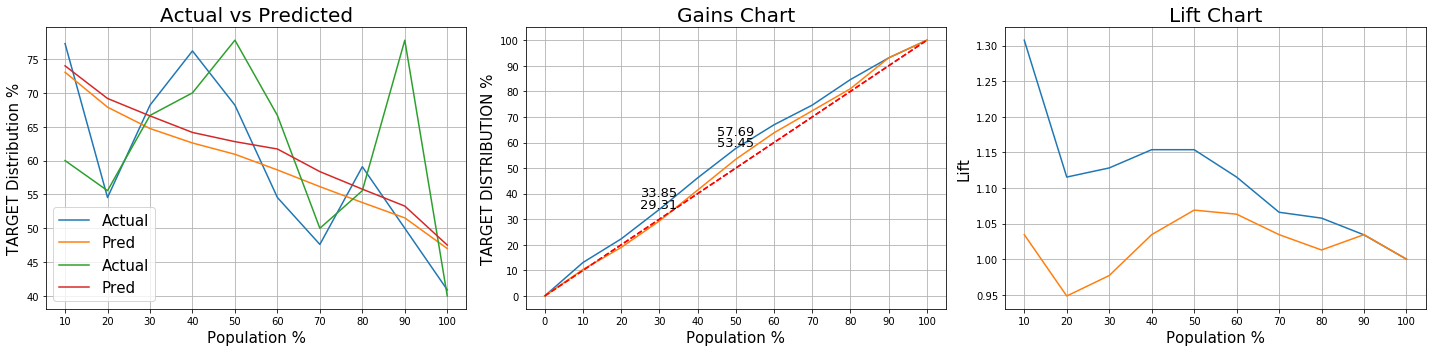

In [79]:
clfLR, scores_train, scores_test, lift_train, lift_test = runModel('LR',fTrain,lTrain,fTest,lTest) #LogisticRegression
printCharts(scores_train,scores_test,lift_train,lift_test)

Random Forest Classifier - n_estimators: 100
accuracy_train: 1.0
accuracy_test: 0.48936170212765956
auc_train: 1.0
auc_test: 0.40708812260536403



Assertivity - Train

PRED     0    1
ACTUAL         
0       88    0
1        0  130



Assertivity - Test

PRED     0   1
ACTUAL        
0       13  23
1       25  33
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib

None
None


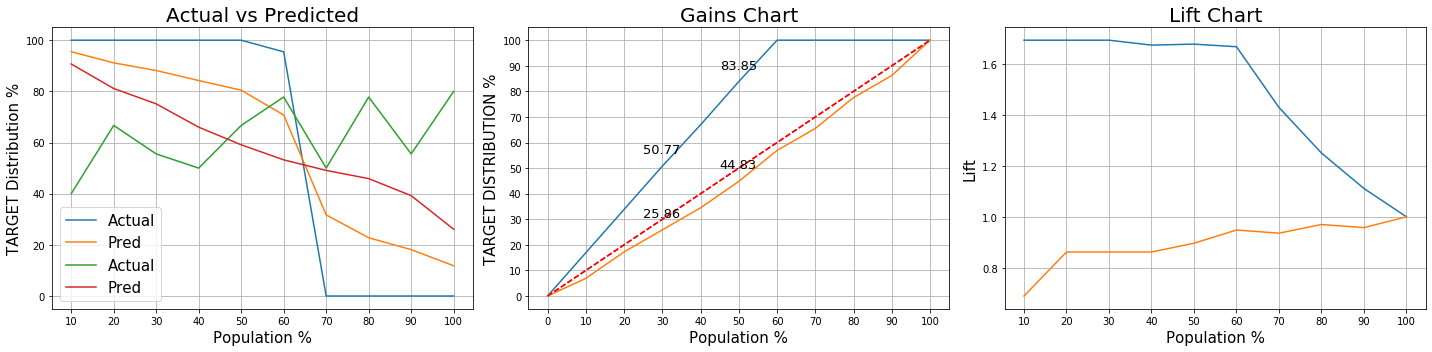

In [80]:
clfRF, scores_train, scores_test, lift_train, lift_test = runModel('RF',fTrain,lTrain,fTest,lTest) #RandomForest
printCharts(scores_train,scores_test,lift_train,lift_test)

Gradient Boost
accuracy_train: 0.9174311926605505
accuracy_test: 0.46808510638297873
auc_train: 0.9901223776223776
auc_test: 0.45162835249042144



Assertivity - Train

PRED     0    1
ACTUAL         
0       73   15
1        3  127



Assertivity - Test

PRED     0   1
ACTUAL        
0       12  24
1       26  32
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib

None
None


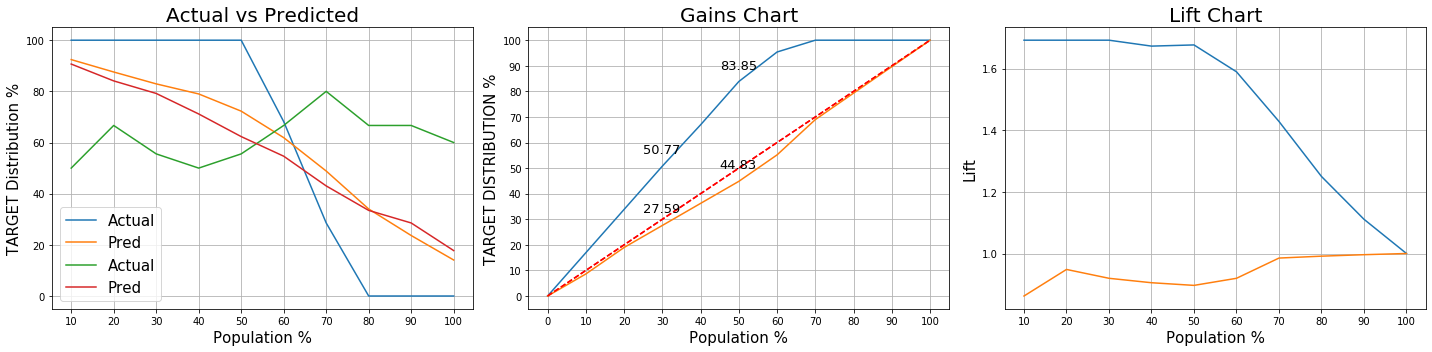

In [81]:
clfGB, scores_train, scores_test, lift_train, lift_test = runModel('GB',fTrain,lTrain,fTest,lTest) #GradientBoost
printCharts(scores_train,scores_test,lift_train,lift_test)

Random Forest - Hyper Parameter Tuning
Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.9s finished


{'n_estimators': 227, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 3, 'bootstrap': True}
accuracy_train: 0.7247706422018348
accuracy_test: 0.6276595744680851
auc_train: 0.7942307692307693
auc_test: 0.5167624521072797



Assertivity - Train

PRED     0    1
ACTUAL         
0       33   55
1        5  125



Assertivity - Test

PRED    0   1
ACTUAL       
0       5  31
1       4  54
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib

None
None


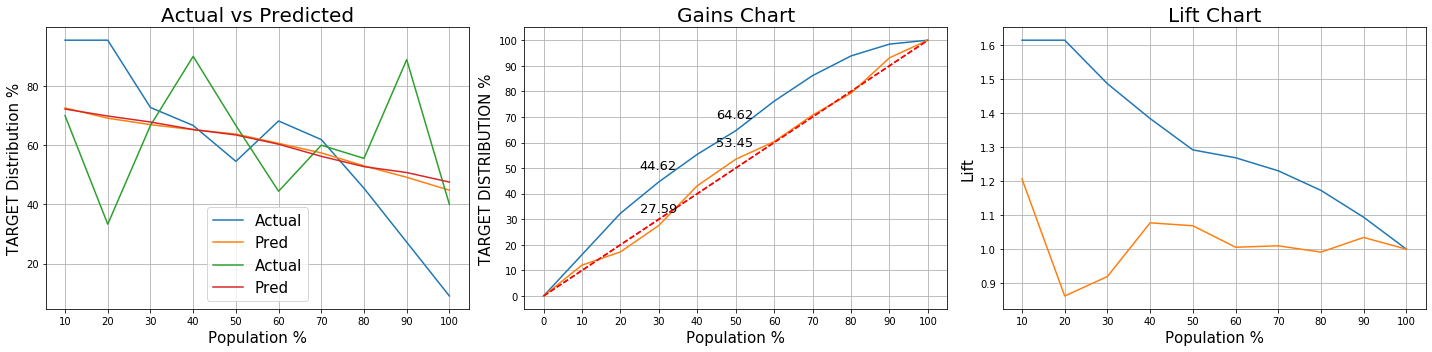

In [82]:
clfRFHP, scores_train, scores_test, lift_train, lift_test = runModel('RFHP',fTrain,lTrain,fTest,lTest) #RandomForestHyperParameter
printCharts(scores_train,scores_test,lift_train,lift_test)

Gradient Boost - Hyper Parameter Tuning
Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.7min finished


{'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
accuracy_train: 0.7110091743119266
accuracy_test: 0.5851063829787234
auc_train: 0.850743006993007
auc_test: 0.4868295019157088



Assertivity - Train

PRED     0    1
ACTUAL         
0       31   57
1        6  124



Assertivity - Test

PRED    0   1
ACTUAL       
0       6  30
1       9  49
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib

None
None


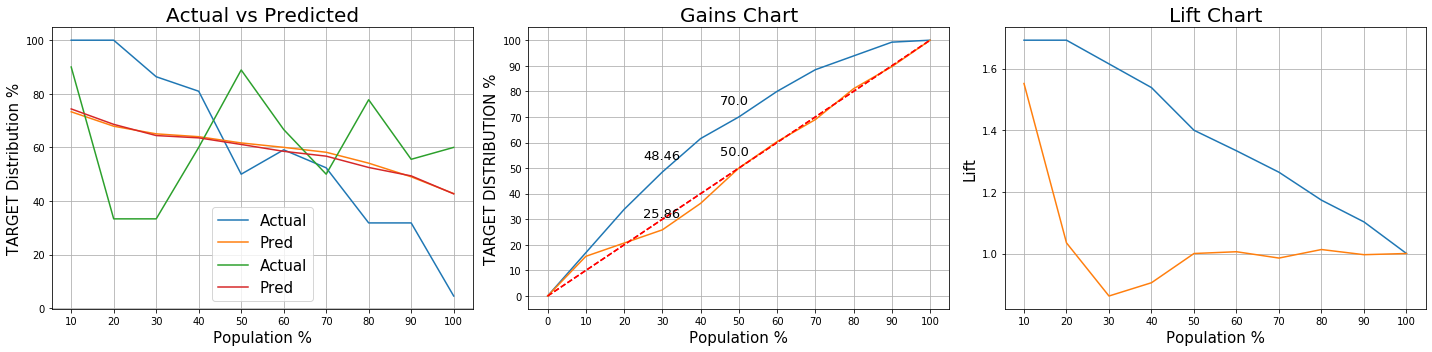

In [83]:
clfGBHP, scores_train, scores_test, lift_train, lift_test = runModel('GBHP',fTrain,lTrain,fTest,lTest) #GradientBoostHyperParameter
printCharts(scores_train,scores_test,lift_train,lift_test)

## Exporting Model

In [84]:
print('Exports')
for i in range(0,len(exports)):
  print('\n\n\n\n###############\n # {}\n\t{}\n'.format(i,exports[i].__class__))
  print('\n\t{}\n\n\n'.format(exports[i]))

Exports




###############
 # 0
	<class 'sklearn.preprocessing._data.StandardScaler'>


	StandardScaler(copy=True, with_mean=True, with_std=True)







###############
 # 1
	<class 'dict'>


	{'TempBulboUmido': GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                      

In [85]:
joblib.dump(exports[0], '/content/drive/My Drive/Persona/scaler')
joblib.dump(exports[1], '/content/drive/My Drive/Persona/binner_model')
joblib.dump(exports[2], '/content/drive/My Drive/Persona/binner_chars')
joblib.dump(exports[3], '/content/drive/My Drive/Persona/binner_proba')
joblib.dump(exports[4], '/content/drive/My Drive/Persona/vars_brutas')
joblib.dump(exports[5], '/content/drive/My Drive/Persona/vars_abertas')
joblib.dump(exports[6], '/content/drive/My Drive/Persona/vars_numeric_zero')
joblib.dump(exports[7], '/content/drive/My Drive/Persona/vars_binners')

['/content/drive/My Drive/Persona/vars_binners']

## Trainning Loop

In [104]:
clf_ = {}
number_of_elements = 25
count = 1
out = display(update_progress(0, 100), display_id=True)
for x in range(1,26):
  print('Model Y = {}'.format(x))
  variaveis_brutas = joblib.load('/content/drive/My Drive/Persona/vars_brutas')
  variaveis_brutas.append('X_{}'.format(x))
  variaveis_todas = joblib.load('/content/drive/My Drive/Persona/vars_brutas')
  variaveis_todas.append('target')
  df01 = dfMerge[variaveis_brutas].copy()
  df01.columns = variaveis_todas
  filter_numeric = joblib.load('/content/drive/My Drive/Persona/vars_numeric_zero')
  df01_1 = df01[filter_numeric]
  df01_2 = df01[df01.columns.difference(filter_numeric)]
  df_numeric = df01_1.fillna(0)
  scaler = joblib.load('/content/drive/My Drive/Persona/scaler')
  df02 = df_numeric.astype(float)
  scaled_fit = scaler.fit_transform(df02)
  df_numeric_scaled = pd.DataFrame(scaled_fit, columns=df_numeric.columns,index=df_numeric.index)
  filter_discretizer = joblib.load('/content/drive/My Drive/Persona/vars_binners')
  binners = joblib.load('/content/drive/My Drive/Persona/binner_model')
  binners_chars = joblib.load('/content/drive/My Drive/Persona/binner_chars')
  binners_probas = joblib.load('/content/drive/My Drive/Persona/binner_proba')
  vars_dis = apply_binner(df01_2[filter_discretizer],filter_discretizer,binners,binners_chars,binners_probas)
  vars_dis.fillna('NA',inplace=True)
  vars_dis.drop(filter_discretizer,axis=1,inplace=True)
  vars_dis.columns = filter_discretizer
  df_dummies = pd.get_dummies(vars_dis,prefix=vars_dis.columns,prefix_sep='_',drop_first=True,columns=vars_dis.columns)
  df_dummies.columns = [col.replace(' ','') for col in df_dummies.columns]
  df_tmp1 = pd.merge(df_numeric_scaled,df_dummies,left_index=True,right_index=True)
  ABT_df = pd.merge(df_tmp2,df01[['target']],left_index=True,right_index=True)
  colunas_ABT = joblib.load('/content/drive/My Drive/Persona/vars_abertas')
  colunas_model = colunas_ABT.copy()
  colunas_model.append('target')
  dfABT_Model = ABT_df[colunas_model]
  train, test = train_test_split(dfABT_Model, test_size = testSize, random_state=666)
  train = train.reset_index(drop=True)
  test = test.reset_index(drop=True)
  fTrain = train[colunas_ABT]
  lTrain = train['target']
  fTest = test[colunas_ABT]
  lTest = test['target']
  clf_[x], scores_train, scores_test, lift_train, lift_test = runModel('LR',fTrain,lTrain,fTest,lTest) #LogisticRegression
  #printCharts(scores_train,scores_test,lift_train,lift_test)
  out.update(update_progress((count / number_of_elements)*100, 100))
  count = count + 1

Model Y = 1


Logistic Regression
accuracy_train: 0.6100917431192661
accuracy_test: 0.6170212765957447
auc_train: 0.6013111888111887
auc_test: 0.5316091954022989



Assertivity - Train

PRED     0    1
ACTUAL         
0       12   76
1        9  121



Assertivity - Test

PRED    0   1
ACTUAL       
0       4  32
1       4  54
Model Y = 2


Logistic Regression
accuracy_train: 0.573394495412844
accuracy_test: 0.5
auc_train: 0.61080344210616
auc_test: 0.48136217211228716



Assertivity - Train

PRED     0   1
ACTUAL        
0       38  59
1       34  87



Assertivity - Test

PRED     0   1
ACTUAL        
0       12  29
1       18  35
Model Y = 3


Logistic Regression
accuracy_train: 0.5963302752293578
accuracy_test: 0.48936170212765956
auc_train: 0.5708245243128963
auc_test: 0.5067934782608696



Assertivity - Train

PRED    0    1
ACTUAL        
0       3   83
1       5  127



Assertivity - Test

PRED     1
ACTUAL    
0       48
1       46
Model Y = 4


Logistic Regression
accuracy_train: 0.5871559633027523
accuracy_test: 0.6382978723404256
auc_train: 0.5196180555555555
auc_test: 0.45637254901960783



Assertivity - Train

PRED      1
ACTUAL     
0        90
1       128



Assertivity - Test

PRED     1
ACTUAL    
0       34
1       60
Model Y = 5


Logistic Regression
accuracy_train: 0.6422018348623854
accuracy_test: 0.6702127659574468
auc_train: 0.563003663003663
auc_test: 0.49974398361495137



Assertivity - Train

PRED      1
ACTUAL     
0        78
1       140



Assertivity - Test

PRED     1
ACTUAL    
0       31
1       63
Model Y = 6


Logistic Regression
accuracy_train: 0.573394495412844
accuracy_test: 0.48936170212765956
auc_train: 0.5764655541292255
auc_test: 0.5930285196921683



Assertivity - Train

PRED     0    1
ACTUAL         
0       19   76
1       17  106



Assertivity - Test

PRED     0   1
ACTUAL        
0       11  36
1       12  35
Model Y = 7


Logistic Regression
accuracy_train: 0.6330275229357798
accuracy_test: 0.44680851063829785
auc_train: 0.5792576218108132
auc_test: 0.4739010989010989



Assertivity - Train

PRED    0    1
ACTUAL        
0       0   77
1       3  138



Assertivity - Test

PRED     1
ACTUAL    
0       52
1       42
Model Y = 8


Logistic Regression
accuracy_train: 0.5688073394495413
accuracy_test: 0.5851063829787234
auc_train: 0.5780710835058661
auc_test: 0.4343137254901961



Assertivity - Train

PRED     0    1
ACTUAL         
0       10   82
1       12  114



Assertivity - Test

PRED    0   1
ACTUAL       
0       2  32
1       7  53
Model Y = 9


Logistic Regression
accuracy_train: 0.6055045871559633
accuracy_test: 0.5957446808510638
auc_train: 0.5933281073077258
auc_test: 0.592911877394636



Assertivity - Train

PRED    0    1
ACTUAL        
0       9   80
1       6  123



Assertivity - Test

PRED    0   1
ACTUAL       
0       2  34
1       4  54
Model Y = 10


Logistic Regression
accuracy_train: 0.5825688073394495
accuracy_test: 0.648936170212766
auc_train: 0.5852311939268461
auc_test: 0.5151515151515151



Assertivity - Train

PRED    0    1
ACTUAL        
0       3   89
1       2  124



Assertivity - Test

PRED    0   1
ACTUAL       
0       1  32
1       1  60
Model Y = 11


Logistic Regression
accuracy_train: 0.591743119266055
accuracy_test: 0.6063829787234043
auc_train: 0.5502745367192862
auc_test: 0.4188508064516129



Assertivity - Train

PRED     0    1
ACTUAL         
0       10   84
1        5  119



Assertivity - Test

PRED    0   1
ACTUAL       
0       0  32
1       5  57
Model Y = 12


Logistic Regression
accuracy_train: 0.5688073394495413
accuracy_test: 0.5106382978723404
auc_train: 0.6133594615319078
auc_test: 0.47509398496240596



Assertivity - Train

PRED     0   1
ACTUAL        
0       30  67
1       27  94



Assertivity - Test

PRED     0   1
ACTUAL        
0       10  28
1       18  38
Model Y = 13


Logistic Regression
accuracy_train: 0.6146788990825688
accuracy_test: 0.648936170212766
auc_train: 0.5531180893409995
auc_test: 0.5588673621460507



Assertivity - Train

PRED    0    1
ACTUAL        
0       1   84
1       0  133



Assertivity - Test

PRED     1
ACTUAL    
0       33
1       61
Model Y = 14


Logistic Regression
accuracy_train: 0.591743119266055
accuracy_test: 0.5638297872340425
auc_train: 0.6079610791685095
auc_test: 0.4666666666666667



Assertivity - Train

PRED     0    1
ACTUAL         
0       10   75
1       14  119



Assertivity - Test

PRED    0   1
ACTUAL       
0       5  34
1       7  48
Model Y = 15


Logistic Regression
accuracy_train: 0.6284403669724771
accuracy_test: 0.6063829787234043
auc_train: 0.5573426573426573
auc_test: 0.49407302038880985



Assertivity - Train

PRED    0    1
ACTUAL        
0       7   81
1       0  130



Assertivity - Test

PRED    0   1
ACTUAL       
0       1  36
1       1  56
Model Y = 16


Logistic Regression
accuracy_train: 0.6192660550458715
accuracy_test: 0.5531914893617021
auc_train: 0.5641835570764236
auc_test: 0.468997668997669



Assertivity - Train

PRED     0    1
ACTUAL         
0       10   77
1        6  125



Assertivity - Test

PRED    0   1
ACTUAL       
0       3  36
1       6  49
Model Y = 17


Logistic Regression
accuracy_train: 0.5871559633027523
accuracy_test: 0.5957446808510638
auc_train: 0.5690923249978368
auc_test: 0.568802781917536



Assertivity - Train

PRED    0    1
ACTUAL        
0       7   84
1       6  121



Assertivity - Test

PRED    0   1
ACTUAL       
0       1  32
1       6  55
Model Y = 18


Logistic Regression
accuracy_train: 0.6559633027522935
accuracy_test: 0.6063829787234043
auc_train: 0.5830244625648627
auc_test: 0.5135135135135136



Assertivity - Train

PRED    0    1
ACTUAL        
0       1   75
1       0  142



Assertivity - Test

PRED     1
ACTUAL    
0       37
1       57
Model Y = 19


Logistic Regression
accuracy_train: 0.591743119266055
accuracy_test: 0.5851063829787234
auc_train: 0.5634526609180386
auc_test: 0.561877667140825



Assertivity - Train

PRED    0    1
ACTUAL        
0       2   87
1       2  127



Assertivity - Test

PRED    0   1
ACTUAL       
0       0  37
1       2  55
Model Y = 20


Logistic Regression
accuracy_train: 0.6467889908256881
accuracy_test: 0.5638297872340425
auc_train: 0.5878235239937369
auc_test: 0.37597791072250347



Assertivity - Train

PRED      1
ACTUAL     
0        77
1       141



Assertivity - Test

PRED     1
ACTUAL    
0       41
1       53
Model Y = 21


Logistic Regression
accuracy_train: 0.6192660550458715
accuracy_test: 0.7127659574468085
auc_train: 0.5869153825358205
auc_test: 0.5584415584415584



Assertivity - Train

PRED    0    1
ACTUAL        
0       1   80
1       3  134



Assertivity - Test

PRED    0   1
ACTUAL       
0       1  27
1       0  66
Model Y = 22


Logistic Regression
accuracy_train: 0.5779816513761468
accuracy_test: 0.5957446808510638
auc_train: 0.5262978142076502
auc_test: 0.5379953379953379



Assertivity - Train

PRED    0    1
ACTUAL        
0       4   92
1       0  122



Assertivity - Test

PRED    0   1
ACTUAL       
0       1  38
1       0  55
Model Y = 23


Logistic Regression
accuracy_train: 0.6192660550458715
accuracy_test: 0.5106382978723404
auc_train: 0.5959310039805397
auc_test: 0.4281179138321996



Assertivity - Train

PRED    0    1
ACTUAL        
0       4   81
1       2  131



Assertivity - Test

PRED    0   1
ACTUAL       
0       0  45
1       1  48
Model Y = 24


Logistic Regression
accuracy_train: 0.6513761467889908
accuracy_test: 0.5957446808510638
auc_train: 0.5905867182462927
auc_test: 0.5728383458646616



Assertivity - Train

PRED    0    1
ACTUAL        
0       1   76
1       0  141



Assertivity - Test

PRED     1
ACTUAL    
0       38
1       56
Model Y = 25


Logistic Regression
accuracy_train: 0.5963302752293578
accuracy_test: 0.6170212765957447
auc_train: 0.5801573426573426
auc_test: 0.5045362903225807



Assertivity - Train

PRED     0    1
ACTUAL         
0       12   76
1       12  118



Assertivity - Test

PRED    0   1
ACTUAL       
0       2  30
1       6  56


In [106]:
joblib.dump(clf_, '/content/drive/My Drive/Persona/models_1_25')

['/content/drive/My Drive/Persona/models_1_25']

# Escoragem

In [0]:
df = pd.DataFrame({'TempBulboSeco': [25.4], 'UmidadeRelativa': [69], 'PressaoAtmEstacao': [920.9], 'TempBulboUmido': [19.2]})

In [151]:
clf_ = joblib.load('/content/drive/My Drive/Persona/models_1_25')
df1 = pd.DataFrame({'REF':['LR']})
for x in range(1,26):
  variaveis_brutas = joblib.load('/content/drive/My Drive/Persona/vars_brutas')
  df01 = df[variaveis_brutas].copy()
  filter_numeric = joblib.load('/content/drive/My Drive/Persona/vars_numeric_zero')
  df01_1 = df01[filter_numeric]
  df01_2 = df01[df01.columns.difference(filter_numeric)]
  df_numeric = df01_1.fillna(0)
  scaler = joblib.load('/content/drive/My Drive/Persona/scaler')
  df02 = df_numeric.astype(float)
  scaled_fit = scaler.fit_transform(df02)
  df_numeric_scaled = pd.DataFrame(scaled_fit, columns=df_numeric.columns,index=df_numeric.index)
  filter_discretizer = joblib.load('/content/drive/My Drive/Persona/vars_binners')
  binners = joblib.load('/content/drive/My Drive/Persona/binner_model')
  binners_chars = joblib.load('/content/drive/My Drive/Persona/binner_chars')
  binners_probas = joblib.load('/content/drive/My Drive/Persona/binner_proba')
  vars_dis = apply_binner(df01_2[filter_discretizer],filter_discretizer,binners,binners_chars,binners_probas)
  vars_dis.fillna('NA',inplace=True)
  vars_dis.drop(filter_discretizer,axis=1,inplace=True)
  vars_dis.columns = filter_discretizer
  df_dummies = pd.get_dummies(vars_dis,prefix=vars_dis.columns,prefix_sep='_',columns=vars_dis.columns)
  df_dummies.columns = [col.replace(' ','') for col in df_dummies.columns]
  ABT_df = pd.merge(df_numeric_scaled,df_dummies,left_index=True,right_index=True)
  colunas_ABT = joblib.load('/content/drive/My Drive/Persona/vars_abertas')
  for col in colunas_ABT:
    if col not in df_dummies.columns:
      ABT_df[col] = 0
  dfABT_Model = ABT_df[colunas_ABT]
  score = pd.DataFrame(clf_[x].predict_proba(dfABT_Model)[:,1], columns = ['SCORE'])
  df1['Y_{}'.format(x)] = score.iloc[0]['SCORE']
df1.drop(['REF'],axis=1,inplace=True)
df1.ge(0.6).astype(int)

,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10,Y_11,Y_12,Y_13,Y_14,Y_15,Y_16,Y_17,Y_18,Y_19,Y_20,Y_21,Y_22,Y_23,Y_24,Y_25
0,1,0,1,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,1,1,0,1,1,1
